In [1]:
import pandas as pd 
import numpy as np
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import tensorflow as tf

csvfile = "Data_actor.csv"  #file name 
#csvfile = "Data_actor2000.pt.csv"  #file name 

In [2]:
data_test= pd.read_csv(csvfile)
data_test.head()

,Episode,Kick_Speed,NN_start_speed,CRS_speed,Rewards,Stop_Distance
0,0,12.58,12.58,0.00,-235.32,66.81
1,1,32.44,32.44,23.42,-553.68,0.16
2,2,33.23,33.23,24.63,-606.88,0.02
3,3,8.77,8.77,24.63,-326.19,82.90
4,4,16.73,16.73,24.63,-91.50,43.90


In [53]:
profile = ProfileReport(data_test, minimal=True)
profile.to_file(output_file="output.html")

In [3]:
failed = data_test[data_test['Stop_Distance'] <= 0]
passed = data_test[data_test['Stop_Distance'] > 0]

print('Size of crashes :',failed.shape[0])  
print('Size of success :',passed.shape[0]) 
print("Percentage of crash cases:{:.2f}".format(failed.shape[0]*100/(failed.shape[0]+passed.shape[0])),"%")
print("Percentage of not crashed cases:{:.2f}".format(passed.shape[0]*100/(failed.shape[0]+passed.shape[0])),"%")

#failed.to_csv("crashed.csv",index=False)
#failed.head()

Size of crashes : 1562
Size of success : 7438
Percentage of crash cases:17.36 %
Percentage of not crashed cases:82.64 %


In [4]:
#passed.to_csv("not_crashed.csv",index=False  )
#passed.head()

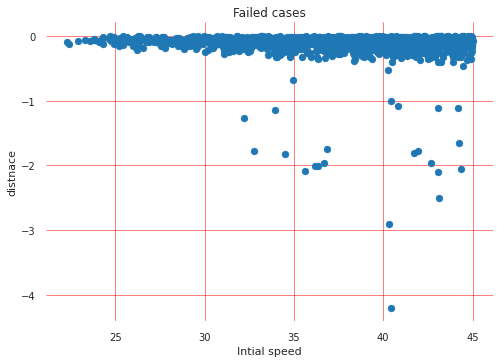

In [4]:
plt.scatter(failed["NN_start_speed"],failed["Stop_Distance"],label='Line 2')
plt.grid(color='r', linestyle='-', linewidth=0.5)
plt.title("Failed cases")
plt.xlabel("Intial speed")
plt.ylabel("distnace")
plt.show()

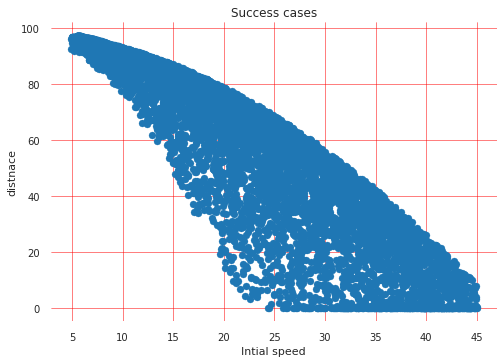

In [5]:
plt.scatter(passed["NN_start_speed"],passed["Stop_Distance"])
plt.grid(color='r', linestyle='-', linewidth=0.5)
plt.title("Success cases")
plt.xlabel("Intial speed")
plt.ylabel("distnace")
plt.show()

In [13]:
data_test.loc[data_test['Stop_Distance'] <= 0, 'test'] = int(1)
data_test.loc[data_test['Stop_Distance'] > 0, 'test'] = int(0)
data_test.head()

,Episode,Kick_Speed,NN_start_speed,CRS_speed,Rewards,Stop_Distance,test
0,0,12.58,12.58,0.00,-235.32,66.81,0.0
1,1,32.44,32.44,23.42,-553.68,0.16,0.0
2,2,33.23,33.23,24.63,-606.88,0.02,0.0
3,3,8.77,8.77,24.63,-326.19,82.90,0.0
4,4,16.73,16.73,24.63,-91.50,43.90,0.0


Total number of episodes: 9000
Number of Pass: 7437
Number of fail: 1562


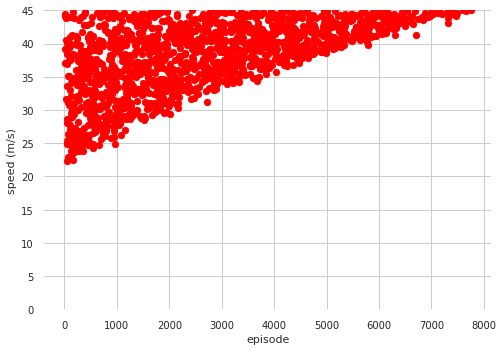

In [36]:
print('Total number of episodes:',data_test['Episode'].shape[0])
start=1
end=9000

fig, ax = plt.subplots()
episode=np.array(data_test['Episode'].values.tolist()[start:end])
test=np.array(data_test['test'].values.tolist()[start:end])
speed=np.array(data_test['NN_start_speed'].values.tolist()[start:end])

indices = test == 0
print('Number of Pass:',indices.sum())
print('Number of fail:',indices.shape[0]-indices.sum())

# normal values
ax.scatter(episode[~indices], speed[~indices], c = 'red',label='fail')
# bad values
#ax.scatter(episode[indices], speed[indices], c = 'grey',label='Pass')
#ax.legend()
ax.set_ylim([0, 45])
plt.xlabel('episode')
plt.ylabel('speed (m/s)')
ax.grid(True) 
plt.show()

Failures:  [191, 169, 160, 151, 138, 134, 125, 104, 101, 79, 70, 54, 46, 21, 16, 3, 0, 0]


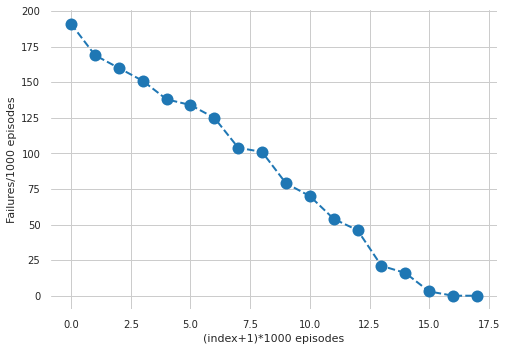

In [8]:
step=500
failure=[]
fig, ax = plt.subplots()
for i in range(int(data_test['Episode'].shape[0]/step)):
    start=step*i
    episode=np.array(data_test['Episode'].values.tolist()[start:start+step])
    test=np.array(data_test['test'].values.tolist()[start:start+step])
    indices = test == 1
    failure.append(indices.shape[0]-indices.sum())
print('Failures: ',failure)
ax.plot(failure,marker='o', linestyle='dashed',linewidth=2, markersize=12)
plt.xlabel('(index+1)*1000 episodes')
plt.ylabel('Failures/1000 episodes')
ax.grid(True) 
plt.show()   

In [26]:
#data for AVF training:
iteration_start=6000
iteration_end=9000
data=data_test[["Episode", "Kick_Speed","test"]][iteration_start:iteration_end]
std=np.std(data[["Episode", "Kick_Speed"]].values,axis=0)
mean=np.mean(data[["Episode", "Kick_Speed"]].values,axis=0)
np.savez('stdmean.npz',std=std, mean=mean)
data[["Episode", "Kick_Speed"]]=np.divide(np.subtract(data[["Episode", "Kick_Speed"]],mean),std)
print('std is:',std)
print('Mean is:',mean)
data.head()

std is: [866.02535567  11.48810554]
Mean is: [7499.5          24.79501667]


,Episode,Kick_Speed,test
6000,-1.731474,1.281759,0.0
6001,-1.730319,-1.188622,0.0
6002,-1.729164,0.881345,0.0
6003,-1.728009,1.715251,1.0
6004,-1.726855,-1.096353,0.0


In [27]:
#AVF Training 


X=data[["Episode","Kick_Speed"]].values
print(X.shape)
Y=data["test"]
print(Y.shape)
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

#test train split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
print(X[1,:].shape)

#callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.998):
      print("\nReached 99% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

# Model

model = tf.keras.models.Sequential([tf.keras.layers.InputLayer(input_shape=(2,)), 
                                    tf.keras.layers.Dense(64, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(32, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid )
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=500, batch_size=8, callbacks=[callbacks]) ;


(3000, 2)
(3000,)
(2,)
Epoch 1/500
252/252 [==============================] - 0s 2ms/step - loss: 0.2212 - accuracy: 0.9438
Epoch 2/500
252/252 [==============================] - 1s 2ms/step - loss: 0.0761 - accuracy: 0.9726
Epoch 3/500
252/252 [==============================] - 1s 2ms/step - loss: 0.0590 - accuracy: 0.9746
Epoch 4/500
252/252 [==============================] - 1s 2ms/step - loss: 0.0456 - accuracy: 0.9851
Epoch 5/500
252/252 [==============================] - 1s 2ms/step - loss: 0.0394 - accuracy: 0.9886
Epoch 6/500
252/252 [==============================] - 1s 2ms/step - loss: 0.0345 - accuracy: 0.9891
Epoch 7/500
252/252 [==============================] - 1s 2ms/step - loss: 0.0323 - accuracy: 0.9876
Epoch 8/500
252/252 [==============================] - 0s 2ms/step - loss: 0.0284 - accuracy: 0.9900
Epoch 9/500
252/252 [==============================] - 0s 2ms/step - loss: 0.0265 - accuracy: 0.9896
Epoch 10/500
252/252 [==============================] - 0s 2ms/step 

252/252 [==============================] - 1s 2ms/step - loss: 0.0103 - accuracy: 0.9950
Epoch 82/500
252/252 [==============================] - 1s 2ms/step - loss: 0.0129 - accuracy: 0.9940
Epoch 83/500
252/252 [==============================] - 1s 2ms/step - loss: 0.0113 - accuracy: 0.9960
Epoch 84/500
252/252 [==============================] - 1s 2ms/step - loss: 0.0098 - accuracy: 0.9955
Epoch 85/500
252/252 [==============================] - 1s 2ms/step - loss: 0.0114 - accuracy: 0.9970
Epoch 86/500
252/252 [==============================] - 1s 2ms/step - loss: 0.0098 - accuracy: 0.9965
Epoch 87/500
252/252 [==============================] - 1s 2ms/step - loss: 0.0115 - accuracy: 0.9955
Epoch 88/500
252/252 [==============================] - 1s 2ms/step - loss: 0.0101 - accuracy: 0.9965
Epoch 89/500
252/252 [==============================] - 1s 2ms/step - loss: 0.0158 - accuracy: 0.9930
Epoch 90/500
252/252 [==============================] - 1s 2ms/step - loss: 0.0100 - accuracy: 

In [28]:
results = model.evaluate(x_test, y_test, batch_size=16)
print('test loss, test acc:', results)

62/62 [==============================] - 0s 1ms/step - loss: 0.0226 - accuracy: 0.9939
test loss, test acc: [0.022645488381385803, 0.9939393997192383]


In [29]:
!mkdir -p saved_model
model.save('saved_model/my_model') 

INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [30]:
# my_model directory
!ls saved_model

# Contains an assets folder, saved_model.pb, and variables folder.
!ls saved_model/my_model

my_model
assets	saved_model.pb	variables


In [31]:
new_model = tf.keras.models.load_model('saved_model/my_model')